### Where does sea-ice in Canada Basin come from and go?

In [2]:
from parcels import FieldSet, ParticleSet, JITParticle, ErrorCode
from parcels import AdvectionRK4
from glob import glob
import numpy as np
from datetime import timedelta as delta
from os import path
import pickle
import netCDF4 as nc
from mpl_toolkits.basemap import Basemap, cm
import matplotlib.pyplot as plt
import datetime

%matplotlib inline

##### Parameters:

In [6]:
# Define boundary latitudes and longitudes for the Laptev Sea region
trajS_bdy1 = 68
trajN_bdy1 = 74
trajE_bdy1 = -170
trajW_bdy1 = -210

trajS_bdy2 = 70
trajN_bdy2 = 75
trajE_bdy2 = -185
trajW_bdy2 = -230

Functions:

In [3]:
def DeleteParticle(particle, fieldset, time):
    print("Particle [%d] lost !! (%g %g %g %g)" % (particle.id, particle.lon, particle.lat, particle.depth, particle.time))
    particle.delete()

In [4]:
def load_tracks(filename):
    nemo_file  = nc.Dataset(filename)

    traj = np.array(nemo_file.variables['trajectory']) # dimensions: number of particles, tracks
    time = np.array(nemo_file.variables['time'])       # units: seconds
    lat  = np.array(nemo_file.variables['lat'])        # degrees North
    lon  = np.array(nemo_file.variables['lon'])        # degrees East

    return traj, time, lon, lat

In [5]:
# Make sure that -180 degrees West is equal to 180 degrees East
def periodicBC(particle, fieldset, time):
    if particle.lon > 180:
        particle.lon -= 360

In [7]:
def check_laptev(CB_traj, CB_lon, CB_lat, CB_time):
    # does the parcel spend time in the laptev sea in the fall?

    Laptev_particle = False
    # At each time step:
    for timestep in range(0,len(CB_traj)):
        if ((CB_lon[timestep]   < trajE_bdy1) & (CB_lon[timestep] > trajW_bdy1) \
            & (CB_lat[timestep] < trajN_bdy1) & (CB_lat[timestep] > trajS_bdy1)) or \
           ((CB_lon[timestep]   < trajE_bdy2) & (CB_lon[timestep] > trajW_bdy2) \
            & (CB_lat[timestep] < trajN_bdy2) & (CB_lat[timestep] > trajS_bdy2)):

            start_time   = datetime.datetime(2015,12,31) - datetime.timedelta(seconds=CB_time[0])
            current_time = start_time - datetime.timedelta(seconds=CB_time[timestep])

            # And is the parcel on the shelf in the fall?
            if current_time.month in [9,10,11,12]:
                Laptev_particle = True
                break
                    
    return Laptev_particle

In [8]:
def parcel_origin(CB_lon, CB_lat, CB_time, CB_traj):

    dim_parc = int((CB_lon.shape[0]/12)/np.ceil(CB_lon.shape[1]/(4*365))) # bottom converts 6 hour to days    
    dim_time = int(12*((CB_lon.shape[0]/dim_parc)/12))

    particles_origin = np.zeros((dim_parc,dim_time))
    # --- Russian shelf in fall = 1
    # --- else = 0

    for release_time in range(0,dim_time):
        for location in range(0,dim_parc):
            ind = location + release_time*dim_parc
            lon_loc = CB_lon[ind,:]
            lat_loc = CB_lat[ind,:]
            time_loc = CB_time[ind,:]
            traj_loc = CB_traj[ind,:]

            Laptev_particle = check_laptev(traj_loc, lon_loc, lat_loc, time_loc)

            if Laptev_particle:
                particles_origin[location, release_time] = 1

    return particles_origin

Load files

In [9]:
# ANHA12 dynamics fields for sea ice from Paul Myers' group
# (http://knossos.eas.ualberta.ca/anha/anhatable.php)
data_path = '/data/brogalla/ANHA12/'
files     = sorted(glob(data_path+'ANHA12-EXH006_5d_icemod_y2013*')+\
                   glob(data_path+'ANHA12-EXH006_5d_icemod_y2014*')+\
                   glob(data_path+'ANHA12-EXH006_5d_icemod_y2015*'))

In [10]:
# ANHA12 grid
mesh = nc.Dataset('/ocean/brogalla/GEOTRACES/data/ANHA12/ANHA12_mesh1.nc')
mesh_lon = np.array(mesh.variables['nav_lon'])
mesh_lat = np.array(mesh.variables['nav_lat'])

mesh_mask = '/ocean/brogalla/GEOTRACES/parcels/parcels_mesh-mask.nc'

Define variables and dimensions from above files:

In [11]:
filenames = {'U': {'lon': mesh_mask, 'lat': mesh_mask, 'data': files},
             'V': {'lon': mesh_mask, 'lat': mesh_mask, 'data': files}}

variables = {'U': 'iicevelu',
             'V': 'iicevelv'}

dimensions= {'U': {'lon': 'nav_lon', 'lat': 'nav_lat', 'time': 'time_counter'},
             'V': {'lon': 'nav_lon', 'lat': 'nav_lat', 'time': 'time_counter'}}

fieldset  = FieldSet.from_nemo(filenames, variables, dimensions)

### Track parcels over a broader region of Canada Basin:

In [13]:
release_lon_CanadaBasin1 = np.linspace(-127, -175, 13)
release_lat_CanadaBasin1 = np.linspace(72.0, 83.5, 12)

release_lon_CanadaBasin2 = np.linspace(-102, -123, 6)
release_lat_CanadaBasin2 = np.linspace(80, 83.5, 4)

release_lon_CanadaBasin3 = np.linspace(-115, -123, 3)
release_lat_CanadaBasin3 = np.linspace(78.2, 79.3, 2)

release_lon_CB1 , release_lat_CB1  = np.meshgrid(release_lon_CanadaBasin1, release_lat_CanadaBasin1)
release_lon_CB2 , release_lat_CB2  = np.meshgrid(release_lon_CanadaBasin2, release_lat_CanadaBasin2)
release_lon_CB3 , release_lat_CB3  = np.meshgrid(release_lon_CanadaBasin3, release_lat_CanadaBasin3)

release_lon  = list(release_lon_CB1.flatten()) + list(release_lon_CB2.flatten()) + list(release_lon_CB3.flatten())
release_lat  = list(release_lat_CB1.flatten()) + list(release_lat_CB2.flatten()) + list(release_lat_CB3.flatten())

In [14]:
print('Number of parcels to track: ', len(release_lon))

Number of parcels to track:  186


<IPython.core.display.Javascript object>


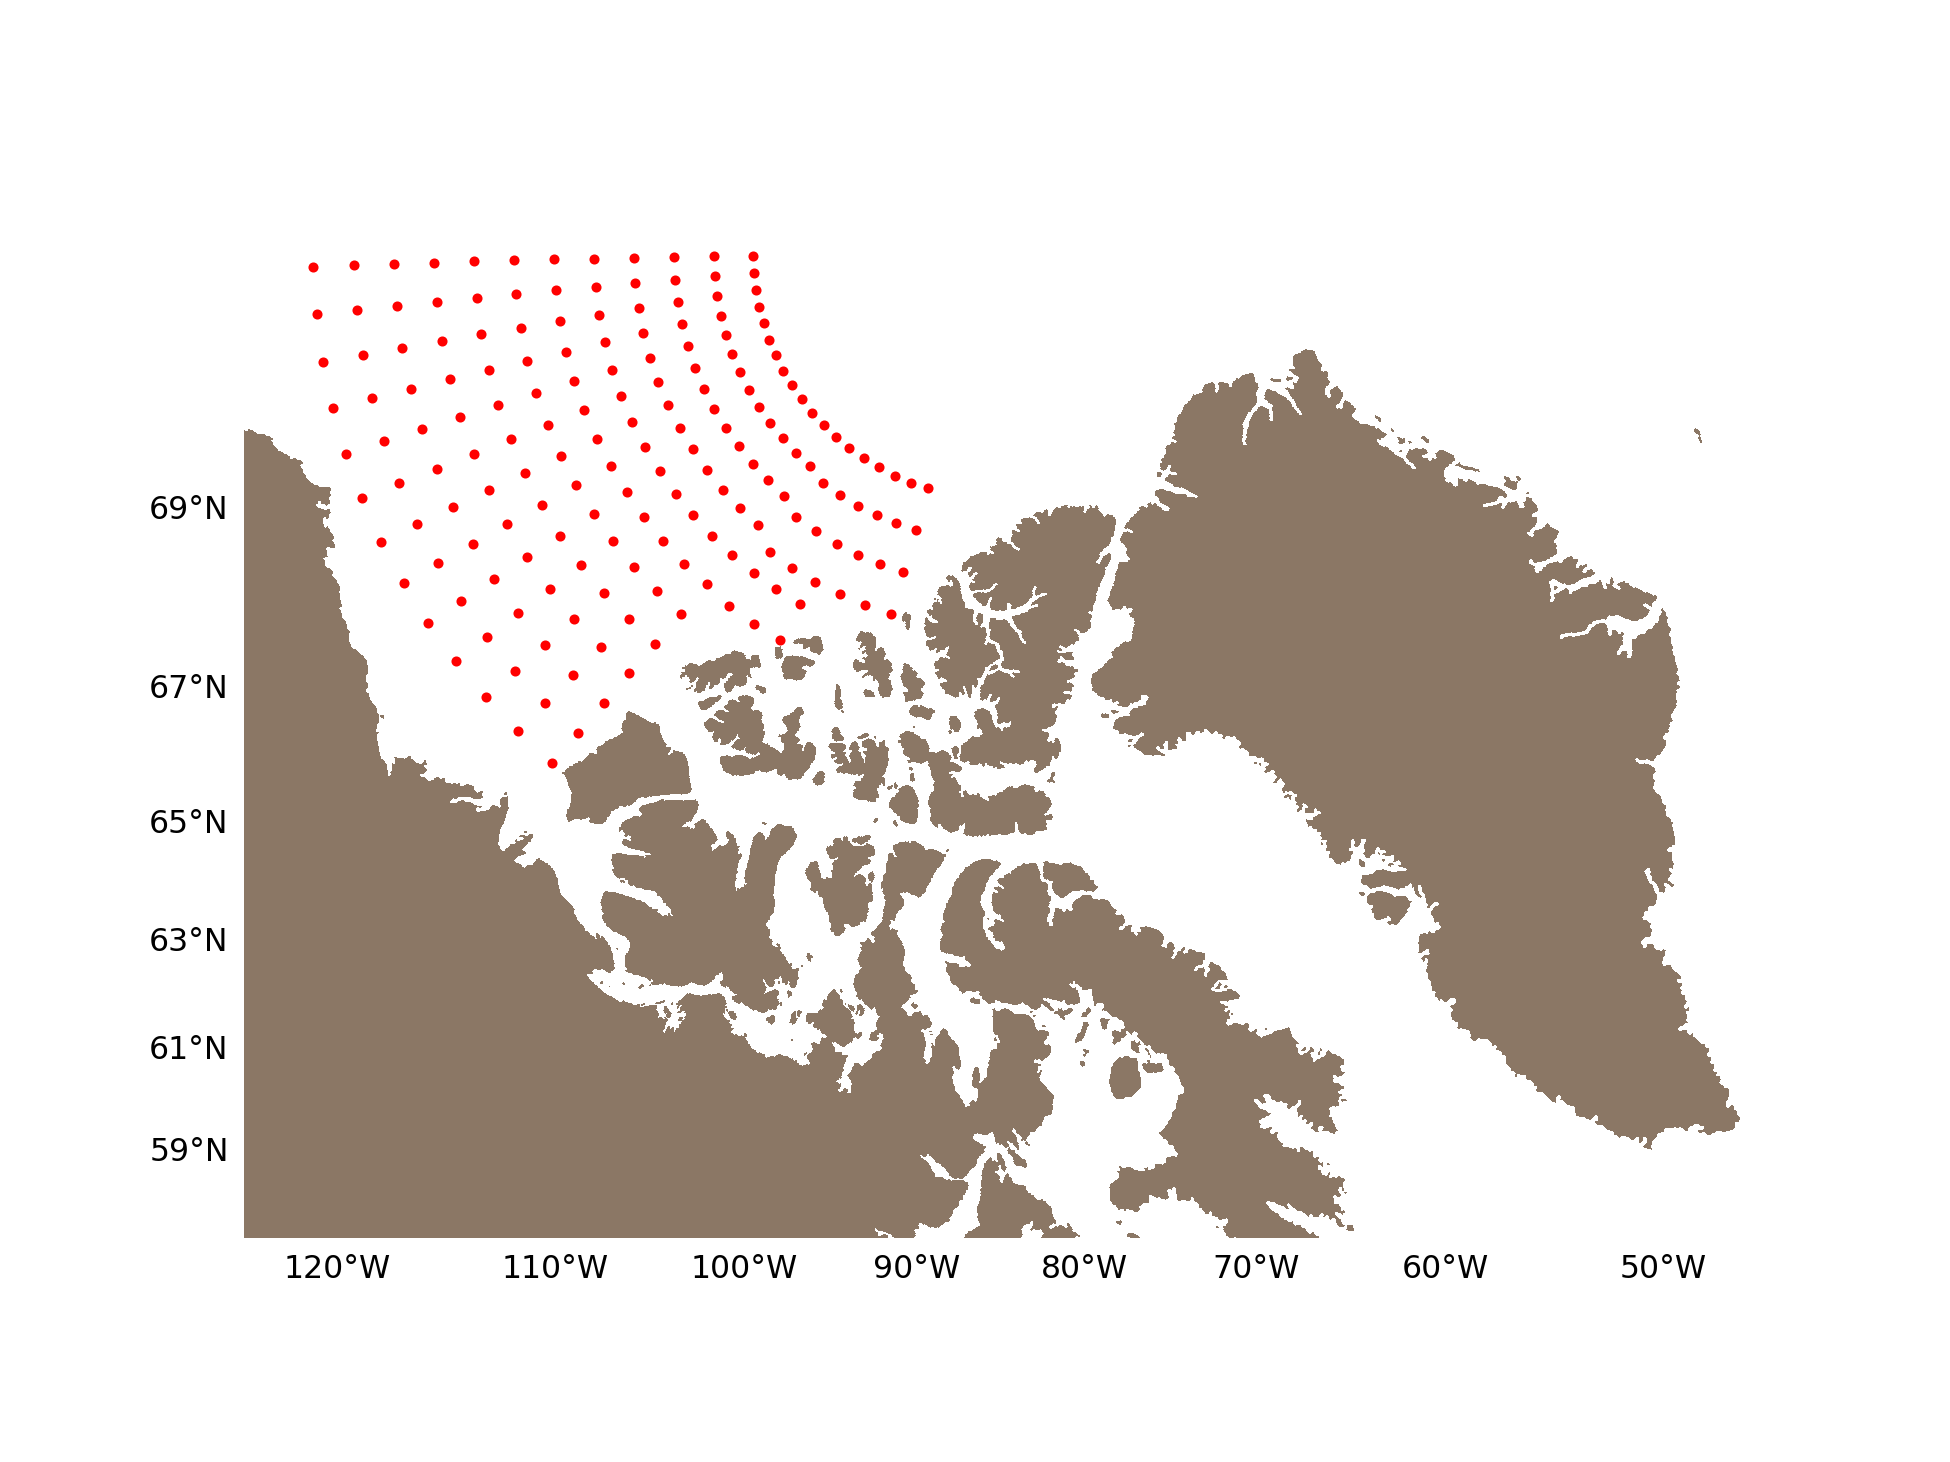

In [11]:
fig, ax1, proj1 = pickle.load(open('/ocean/brogalla/GEOTRACES/pickles/mn-reference.pickle','rb'))

x_part, y_part  = proj1(release_lon, release_lat)

proj1.scatter(x_part, y_part, s=12, zorder=3, c='r') # points at which the particles are released

In [16]:
pset_CB  = ParticleSet.from_list(fieldset=fieldset,  
                                 pclass=JITParticle,     
                                 lon=release_lon,     
                                 lat=release_lat,
                                 repeatdt=3600*24*(365/12.0)) # release parcels every month

output_file_CB = pset_CB.ParticleFile(name="Particles_CB-20200205-extended-region2.nc", outputdt=delta(hours=6))
kernels_CB     = pset_CB.Kernel(AdvectionRK4) + periodicBC

Exception ignored in: <function ParticleFile.__del__ at 0x7ff65db01ea0>
Traceback (most recent call last):
  File "/home/brogalla/anaconda3/lib/python3.7/site-packages/parcels/particlefile.py", line 195, in __del__
    self.close()
  File "/home/brogalla/anaconda3/lib/python3.7/site-packages/parcels/particlefile.py", line 200, in close
    self.export()
  File "/home/brogalla/anaconda3/lib/python3.7/site-packages/parcels/particlefile.py", line 352, in export
    raise RuntimeError("No npy files found in %s" % self.tempwritedir_base)
RuntimeError: No npy files found in out-EEZUNQQB


In [17]:
pset_CB.execute(kernels_CB, dt=-delta(hours=1), endtime=0, output_file=output_file_CB, 
                recovery={ErrorCode.ErrorOutOfBounds: DeleteParticle})
output_file_CB.export()

INFO: Compiled JITParticleAdvectionRK4periodicBC ==> /tmp/parcels-2672/1aa0256140c7804fbe515e66e115a933_0.so
INFO: Temporary output files are stored in out-TDUYJSYQ.
INFO: You can use "parcels_convert_npydir_to_netcdf out-TDUYJSYQ" to convert these to a NetCDF file during the run.
100% (94176000.0 of 94176000.0) |########| Elapsed Time: 0:19:38 Time:  0:19:38
